In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import nltk
import re
en_dict = set(nltk.corpus.words.words())
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='monospace')

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1558 non-null   object 
 1   wins            1558 non-null   int64  
 2   kills           1558 non-null   int64  
 3   kdRatio         1558 non-null   float64
 4   killstreak      1558 non-null   int64  
 5   level           1558 non-null   int64  
 6   losses          1558 non-null   int64  
 7   prestige        1558 non-null   int64  
 8   hits            1558 non-null   int64  
 9   timePlayed      1558 non-null   int64  
 10  headshots       1558 non-null   int64  
 11  averageTime     1558 non-null   float64
 12  gamesPlayed     1558 non-null   int64  
 13  assists         1558 non-null   int64  
 14  misses          1558 non-null   int64  
 15  xp              1558 non-null   int64  
 16  scorePerMinute  1558 non-null   float64
 17  shots           1558 non-null   i

In [4]:
df['winRate']        = df['wins'] / (df['wins'] + df['losses'])
df['killsPerGame']   = df['kills'] / df['gamesPlayed']
df['deathsPerGame']  = df['deaths'] / df['gamesPlayed']
df['assistsPerGame'] = df['assists'] / df['gamesPlayed']
df['hitRate']        = df['hits'] / df['shots']
df['headshotRate']   = df['headshots'] / df['shots']
df['winRateAlt']     = df['winRate'] * np.log(df['gamesPlayed'])
df['kdRatioAlt']     = df['kdRatio'] * np.log(df['gamesPlayed'])
df.replace([np.nan, np.inf, -np.inf], 0, inplace=True)

In [5]:
from sklearn.cluster import KMeans

In [6]:
clusters = KMeans(n_clusters=4).fit(df[['winRateAlt', 'kdRatioAlt']])
df['skillTier'] = clusters.labels_
centers = [(x, y) for x, y in clusters.cluster_centers_]
centers_sorted = sorted(centers)
df['skillTier'] = df['skillTier'].apply(lambda idx: centers_sorted.index(centers[idx]) + 1)

In [7]:
for name in df['name']:
    print(name)

RggRt45#4697369
JohniceRex#9176033
bootybootykill#1892064
JNaCo#5244172
gomezyayo_007#6596687
Brxndoon7-LK#4002715
bdooory_ab#7095171
ahevepluto#3505304
MilkyLemonz-_-#5981249
RPDUNKduo#8122914
BOBOQQ3#7928912
Rachetevolution
CzarnyDelfinek#9059572
Damian291207#7986887
SanDrasoSa
DrunkUnc92#7705654
whoshotghost#1916366
Nsory_1#5583298
LimpThaDon
DeGiove#5248918
TawheedAhmed42
teruteru_yt_#6461227
edgexgaming8901#9276950
BrunoMarchione
SlaPzz#6879518
ferni775#9063204
HORUS REED#8123889
CohesiveMango93#8505922
Bobdustt#2422031
caliopez99#8569536
EH4B_367#1401846
sammy7227#7543148
WilcyWilson#2599001
URjustBADXD#7190593
DaydayLadd96#1594916
S3ND3RBUB12#9216137
Die#1566463
Jay-WKT#9248671
McWiggins14#5533106
SharkPawgin#5823839
Manuel Alarcon1#6037069
LEAN GAL#3205759
Ludsghy#4258818
Macavic#1093672
swayfaze097#4838954
Jacyków#9892624
Sir_Luffwaffles1#7708807
Grrrr pow#5106418
DeadShot1687#6299823
leandr1nho13#4383266
Blom-Tiee#6925955
Unfinishe#7062263
Passion_Divine#1903567
Sup Solaay#96

> Notice the hashtag followed by a string of numbers at the end of most names. These are *Activision IDs* that
> we shall remove from the data. There are also names with foreign characters (Korean, Japanese, Chinese etc). We
> will create a new column to denote the presence of these characters.

In [8]:
df['name']      = df['name'].apply(lambda s: re.sub(r'#\d+$', '', s))
df['isEnglish'] = df['name'].apply(lambda s: 'Yes' if s.isascii() else 'No')

In [9]:
df['nameLength'] = df['name'].apply(lambda s: len(s))

<Axes: xlabel='nameLength', ylabel='Count'>

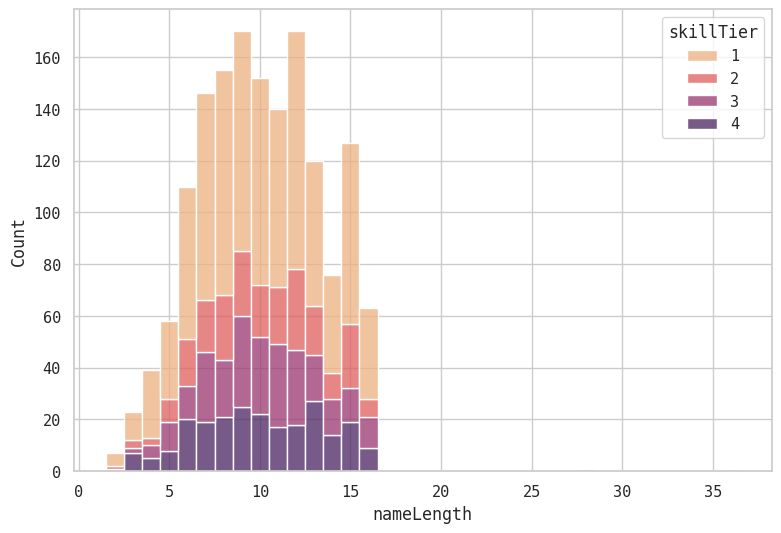

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
sns.histplot(data=df,
             x='nameLength',
             discrete=True,
             hue='skillTier',
             palette='flare',
             multiple='stack')

<Axes: xlabel='skillTier', ylabel='Count'>

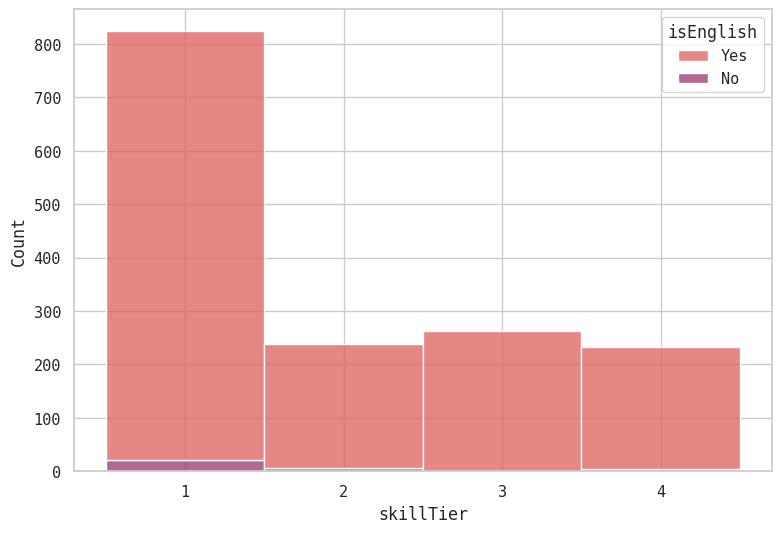

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
axes.set_xticks(range(1, 5))
sns.histplot(data=df,
             x='skillTier',
             discrete=True,
             hue='isEnglish',
             palette='flare',
             multiple='stack')

In [12]:
def get_en_words(s):
    return [''.join(ng) for ng in nltk.everygrams(s) if ''.join(ng).lower() in en_dict and len(''.join(ng)) >= 1]

In [13]:
for name in df[df['skillTier'] == 4]['name']:
    print(name)
    print(get_en_words(name))
    print()

Brxndoon7-LK
['B', 'r', 'x', 'n', 'd', 'do', 'doon', 'o', 'o', 'on', 'n', 'L', 'K']

MilkyLemonz-_-
['M', 'Mi', 'Mil', 'Milk', 'Milky', 'i', 'ilk', 'l', 'k', 'kyL', 'kyLe', 'y', 'L', 'Lemon', 'e', 'em', 'm', 'mo', 'mon', 'o', 'on', 'n', 'z']

Nsory_1
['N', 's', 'so', 'sory', 'o', 'or', 'ory', 'r', 'y']

DeGiove
['D', 'De', 'DeG', 'e', 'G', 'Gio', 'i', 'io', 'o', 'v', 'e']

HORUS REED
['H', 'HO', 'O', 'OR', 'R', 'U', 'US', 'S', 'R', 'RE', 'REE', 'REED', 'E', 'E', 'D']

FaZe Splitter
['F', 'Fa', 'FaZe', 'a', 'Z', 'e', 'S', 'Split', 'Splitter', 'p', 'l', 'li', 'lit', 'litter', 'i', 'it', 't', 't', 'te', 'e', 'er', 'r']

Russbuck
['R', 'u', 'us', 's', 's', 'b', 'bu', 'buck', 'u', 'c', 'k']

AskarkGG
['A', 'As', 'Ask', 'Askar', 's', 'k', 'ka', 'a', 'ar', 'ark', 'r', 'k', 'G', 'G']

JustZiggy
['J', 'Just', 'u', 'us', 'ust', 's', 'st', 't', 'Z', 'Zig', 'i', 'g', 'g', 'y']

infamousabe84
['i', 'in', 'infamous', 'n', 'f', 'fa', 'fam', 'famous', 'a', 'am', 'm', 'mo', 'mou', 'o', 'u', 'us', 's', 